In [1]:
import pandas as pd
import networkx as nx
import os
import json
import powerlaw as pl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
from pathlib import Path
import ipynbname#necessary to get filepath to jupyter notebook file

_FILE_DIR = ipynbname.path().parent#obtain directory of this file
_PROJ_DIR = _FILE_DIR.parent.parent#obtain main project directory
_DATA_DIR = _PROJ_DIR / "dataset"
_EXTRACT_DIR = _PROJ_DIR / "dataExtracted"
_VIS_DIR = _PROJ_DIR / "visualizations"

In [2]:
#first, get the landpoint coordinates:
landPointDf = pd.read_csv(str(_EXTRACT_DIR / "landpoints.csv"))

cityLookup = {}
for l in landPointDf.itertuples():
    #add the city name for all 4 possible coordinates
    longitude = int(l.longitude)
    latitude = int(l.latitude)
    cityLookup[(longitude, latitude)] = l.description
    cityLookup[(-longitude, latitude)] = l.description
    cityLookup[(longitude, -latitude)] = l.description
    cityLookup[(-longitude, -latitude)] = l.description
    
#make a set with all the landing point coordinates
landPointCoords = set(cityLookup.keys())

In [3]:
#now extract a big set that contains all the coorinates that appear multiple times (important coordinates!)
# Directory with .geojson files

def normCoord(long, lat):
    """Converts floating point coordinates to integers for easier comparisons!"""
    return (int(round(long * 1e6)), int(round(lat * 1e6)))

def coordBack(normedCoord):
    """Get the coord back from int to float"""
    return (float(normedCoord[0]) * 1e-6, float(normedCoord[1] * 1e-6))

# Loop through all files in the directory
cableCoords = []
for filename in os.listdir(str(_DATA_DIR / "cablesGeojson")):#iterate over all .geojson files
    if filename.endswith(".geojson"):
        filepath = os.path.join(str(_DATA_DIR / "cablesGeojson"), filename)
        #print(f"Processing {filepath} ...")

        # Load geojson file
        with open(filepath, "r", encoding="utf-8") as f:
            data = json.load(f)

        # Extract cable info
        for feature in data["features"]:
            coords = feature["geometry"].get("coordinates", [])
            if not coords:
                raise ValueError#this should never happen, cables should always have some coordinates!
            coords = [normCoord(c[0], c[1]) for c in coords]#get a list of tuples of coordinates of this cable segment
            cableCoords.extend(coords)#add the coordinates to the list
            
coordSet = set()
duplicateCoordSet = set()#set that will contain all the cable coordinates that appear multiple times
for c in cableCoords:
    if abs(c[0]) == 180000000:#cables at the 180th longitude have to be marked as important always, otherwise connections accross this border won't appear
        duplicateCoordSet.add(c)
    elif c not in coordSet:
        coordSet.add(c)
    else:
        duplicateCoordSet.add(c)#we found a duplicate

In [4]:
relevantCoords = duplicateCoordSet.union(landPointCoords)#these will be all the important coordinates!
#now go through all the cables again and for each one add edges between all pairs of relevant coordinates with weight equal to the cable's capacity

oG = nx.Graph()
cableCapacities = pd.read_csv(str(_EXTRACT_DIR / "cablesWithCapacity.csv"))

oneCount = 0#how often was there a cable that wasn't added because only 1 of its coordinates was important?
zeroCount = 0#how often was there a cable that had no relevant coordinate at all???

# Loop through all files in the directory
for filename in os.listdir(str(_DATA_DIR / "cablesGeojson")):
    if filename.endswith(".geojson"):
        filepath = os.path.join(str(_DATA_DIR / "cablesGeojson"), filename)

        # Load geojson file
        with open(filepath, "r", encoding="utf-8") as f:
            data = json.load(f)
        
        # Extract cable info
        for feature in data["features"]:
            name = feature["properties"].get("Name", "Unknown")
            coords = feature["geometry"].get("coordinates", [])
            if not coords:
                raise ValueError#shouldn't happen
            coords = [normCoord(c[0], c[1]) for c in coords]#get a list of tuples of coordinates of this cable segment
            relevantCs = [c for c in coords if c in relevantCoords]#get only the relevant coordinates from this cable segment
            for i in range(len(relevantCs)):
                if abs(relevantCs[i][0])==180000000:
                    relevantCs[i] = (abs(relevantCs[i][0]), relevantCs[i][1])
            if len(relevantCs) == 0:#add the edge anyways, both endpoints will be marked as "undersea"
                oG.add_edge(coords[0], coords[-1], name=name, capacity=cableCapacities[cableCapacities["name"] == name]["capacity"].values[0])#add the edge with the cable capacity & name
                zeroCount+=1
            if len(relevantCs) == 1:
                oG.add_node(relevantCs[0], description="singleton")#WARNING: this name will actually be overwritten by <cityname> if this is a city!
                oneCount+=1
            for i in range(len(relevantCs)-1):#add edge between adjacent important points (adjacent on the cable)
                oG.add_edge(relevantCs[i], relevantCs[i+1], name=name, capacity=cableCapacities[cableCapacities["name"] == name]["capacity"].values[0])#add the edge with the cable capacity & name


print(oneCount)
print(zeroCount)                 
print(oG)

58
6
Graph with 1283 nodes and 1531 edges


In [5]:
#now rename the stuff

# Build a mapping old_node -> new_node_id
mapping = {}
new_attrs = {}
unique_countries = set()
for idx, node in enumerate(oG.nodes()):
    lon, lat = node
    city_name = None
    #now try to match to a city - country
    if (lon, lat) in cityLookup:
        city_country_name = cityLookup.get((lon, lat)).strip(')').split(' (')
        #print(city_country_name)
        city_name = city_country_name[0]
        country_name = city_country_name[-1]
        #print(city_name)
        #print(country_name)
    else:
        city_name = "undersea"
        country_name = "undersea"
    
    unique_countries.add(country_name)
    mapping[node] = idx  # old coordinate node -> new integer id
    realCoords = coordBack((lon, lat))
    new_attrs[idx] = {
        "lon": realCoords[0],#assign the proper coordinate!
        "lat": realCoords[1],
        "city": city_name,
        "country" : country_name,
        'meta' : False
    }

# Relabel nodes
oG = nx.relabel_nodes(oG, mapping)

# Add the attributes
nx.set_node_attributes(oG, new_attrs)

In [6]:
#remove redundant nodes: (the ones on the seafloor that connect to the same cable twice)
for n, d in list(oG.nodes(data=True)):
    if d["city"] == "undersea":
        if oG.degree[n] == 2:
            edges = list(oG.edges(n, data=True))
            if edges[0][2]["name"] == edges[1][2]["name"]:
                neighbors = list(oG.neighbors(n))#there will be 2 neighbors
                oG.add_edge(neighbors[0], neighbors[1], name=edges[0][2]["name"], capacity=edges[0][2]["capacity"])#add an edge between the two neighbors with the same cable name & capacity
                oG.remove_node(n)
                
print(oG)

Graph with 1031 nodes and 1279 edges


In [7]:
G = oG.copy()
unique_countries.remove("undersea")
unique_countries.remove("")
unique_countries.remove('UK')
unique_countries.remove('Scotland')
unique_countries.remove('Oregon')

In [8]:
# unite the united kingdom (and Oregon !!)
for node, data_node in G.nodes(data= True):
        # for nodes in that country
        if data_node['country'] in ['UK', 'Scotland']:
                nx.set_node_attributes(G, {node: {'country' : 'United Kingdom'}})
        
        if data_node['country'] == 'Oregon':
                nx.set_node_attributes(G, {node: {'country' : 'USA'}})

In [9]:
# obtain degree frequencies
deg_freq_oG = {}
for n, d in oG.degree:
    deg_freq_oG.setdefault(d, 0)
    deg_freq_oG[d] += 1

# sort it bc why not
deg_freq_oG = dict(sorted(deg_freq_oG.items(), key= lambda x:x[0]))

# compute CCDF ~ inverse CDF: cumulative sum from last to first
ccdf_oG = list(np.cumsum(list(deg_freq_oG.values())[::-1]))[::-1]
ccdf_oG = np.array(ccdf_oG) / ccdf_oG[0]  # normalize it

C:\Users\shere\AppData\Local\Temp\ipykernel_21648\1270882290.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


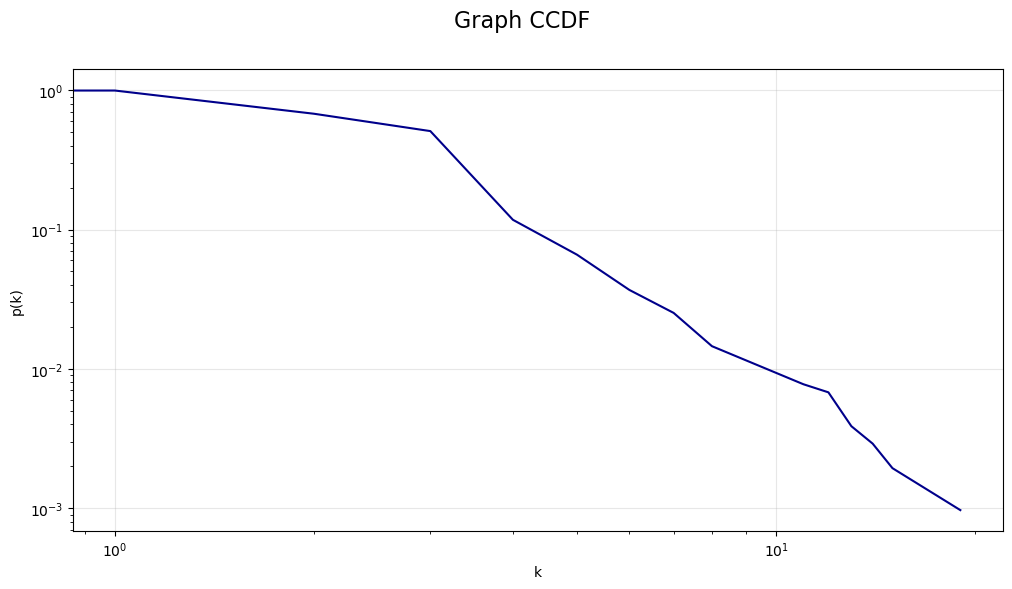

In [10]:
# plot results
fig = plt.figure(figsize=(12, 6))
fig.suptitle("Graph CCDF", fontsize=16)

# plot for real graph ccdf
ax1 = fig.add_subplot(1, 1, 1)
ax1.loglog(list(deg_freq_oG.keys()), ccdf_oG, color= 'darkblue')
ax1.grid(alpha= 0.3)

ax1.set_xlabel('k')
ax1.set_ylabel('p(k)')

fig.show()

In [11]:
# store leftover countries
zero_countries = {}

# iterate through countries
for idx, country in enumerate(unique_countries):

    nodes = []
    cords = {'lon' : [], 'lat' : []}
    max_weight = 0
    
    # iterate through nodes
    for node, data_node in G.nodes(data= True):
        # for nodes in that country
        if data_node['country'] == country:
            
            nodes.append(node)

            cords['lon'].append(data_node['lon'])
            cords['lat'].append(data_node['lat'])

            # update the maximum capacity connected to the country
            for u, v, data_edge in G.edges(node, data= True):
                print(u, v)
                if data_edge['capacity'] > max_weight:
                    max_weight = data_edge['capacity']
    
    # if country has only one node -> turn into metanode
    if len(nodes) == 1:
        nx.set_node_attributes(G, {nodes[0] : {'country' : country, 'city' : f"{country} Metanode", 'meta' : True}})
    
    # if no weight can be computed, store for later
    if max_weight == 0:
        zero_countries[country] = {'nodes' : nodes, 'id' : idx}

    new_lon = np.mean(cords['lon'])
    new_lat = np.mean(cords['lat'])

    # create country metanode
    G.add_node(f"Metanode {idx}", lon= new_lon, lat= new_lat, country= country, city= f"{country} Metanode", meta= True)

    # link new inter-country edges with the computed national maximum
    # to compensate for unrealistic sparse land connections
    for i in range(len(nodes)):
        G.add_edge(f"Metanode {idx}" ,nodes[i], name= "terrestrial", capacity= max_weight)

print(zero_countries)

142 140
142 220
142 221
142 414
142 980
142 1279
146 136
146 145
146 966
221 142
221 222
917 915
122 121
49 50
49 1033
1011 126
1011 1252
1275 1272
14 7
14 188
14 1081
39 35
39 36
39 1181
39 1091
116 115
116 339
116 117
375 374
375 376
375 1016
905 904
1020 1019
165 9
165 40
165 163
165 190
165 168
165 766
165 1092
183 175
183 182
447 176
447 196
447 1090
447 1093
468 191
468 466
468 467
1216 196
1216 1215
1216 1226
169 42
169 168
169 759
180 179
180 181
180 199
180 875
181 179
181 180
181 448
181 1150
181 208
198 197
198 199
198 302
198 470
198 471
198 877
198 976
199 180
199 197
199 198
199 288
199 302
199 877
199 1219
229 227
442 440
442 1096
471 101
471 198
471 470
759 168
759 169
759 444
759 760
760 759
766 165
766 168
850 849
890 168
891 168
996 995
996 997
998 999
1186 822
1186 1183
1186 1207
1208 954
216 215
216 217
217 216
217 218
218 217
218 219
218 916
973 971
1211 831
1111 1107
1125 1117
219 218
219 220
219 915
219 980
220 142
220 219
969 965
969 966
978 979
1164 970
1165 1

In [12]:
gcc_nodes = max(nx.connected_components(G.to_undirected()), key=len)
GCC = G.subgraph(gcc_nodes).copy()
#print(GCC.edges(data= True))

In [13]:
# store edges with no associated weight
edges_to_process = []

for u, v, d in list(GCC.edges(data=True)):
    if d['name'] != 'terrestrial':
        capacity = d['capacity']
        if capacity == 0:
            edges_to_process.append((u, v))
        else:
            GCC[u][v]['iteration'] = 0


# store edge pair with new weight

edges_to_reprocess = []
iteration = 1
# iterate through edges
while edges_to_process:

    # store edge pair with new weight
    new_weights = {}
    edges_to_reprocess = []

    for u, v in edges_to_process:

        # store all weights of edges that have an endpoint in either u or v
        u_edges = list(GCC.edges(u, data= True))
        v_edges = list(GCC.edges(v, data= True))


        u_weights = [d['capacity'] for _, _, d in u_edges if d['capacity'] > 0]
        v_weights = [d['capacity'] for _, _, d in v_edges if d['capacity'] > 0]      
        
        # neither node has non-zero adjacent edge
        if (not u_weights) and (not v_weights):
            edges_to_reprocess.append((u, v))

        # if either u or v only have zero weight edges, use the other node's median
        else:
            if u_weights == []:
                new_weight = np.median(v_weights)
            
            elif v_weights == []:
                new_weight = np.median(u_weights)

            # in normal cases, the estimate is equal to the smaller maximum weight between edges of u and edges of v
            else:
        
                max_weight_u = np.max(u_weights)
                max_weight_v = np.max(v_weights)
                
                new_weight = min(max_weight_u, max_weight_v)

            # store the edge's capacity
            
            new_weights[(u, v)] = [new_weight, iteration]
    

    iteration += 1
    edges_to_process = edges_to_reprocess
    #print(len(edges_to_process))
    #print(len(new_weights))
    for k, v in new_weights.items():
        if v[0] == 0:
            print(k, v[0])
        GCC[k[0]][k[1]]['capacity'] = v[0]
        GCC[k[0]][k[1]]['iteration'] = v[1]

print(f"All edge capacities estimated after {iteration} iterations.") 


All edge capacities estimated after 5 iterations.


In [14]:
# iterate through leftover countries
for country, country_dict in zero_countries.items():

    max_weight = 0
    
    # iterate through nodes
    for node in country_dict['nodes']: 
        
        if GCC.has_node(node):
        # update the maximum capacity connected to the country
            for _, _, d in GCC.edges(node, data= True):
                if d['capacity'] > max_weight:
                    max_weight = d['capacity']
    
    # link new inter-country edges with the computed national maximum
    # to compensate for unrealistic sparse land connections
    idx = country_dict['id']
    for u, v, d in GCC.edges(f"Metanode {idx}", data= True):
        d['capacity'] = max_weight
        nx.set_edge_attributes(GCC, {(u, v) : d})

    if max_weight:
        print(end= '')
        # print(f"{country}: new land capacity is {max_weight}")
    else:
        print(f"{country}: not in GCC")
    

Romania: not in GCC


In [15]:
# quick check that we don't have zero-weight edges
x = 0
check = set()
for u, v, d in list(GCC.edges(data=True)):
    capacity = d['capacity']
    check.add(type(capacity))
    if capacity == 0:
        x += 1
print(x)
print(check)

0
{<class 'numpy.float64'>}


### save the graph to graphml file

In [16]:
nx.write_graphml(GCC, str(_EXTRACT_DIR / "THE_GRAPH.graphml"))

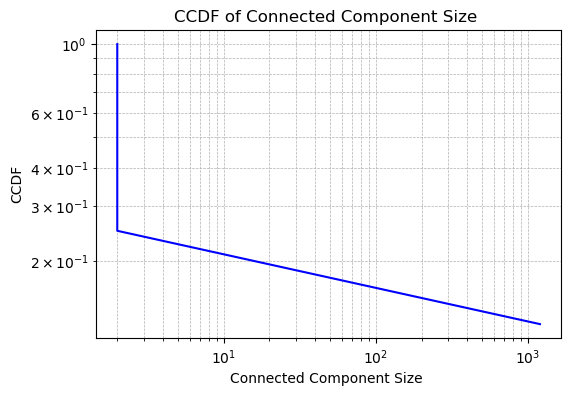

Sizes of the 10 largest connected components:
[1201, 2, 2, 2, 2, 2, 2, 2]


In [17]:
# get size of largest connected components:
#get size of the connected components:

sizesCC = [len(CC) for CC in nx.connected_components(G)]

def plotCCDF(data, dataName):
    """
    Plots the CCDF (Complementary Cumulative Distribution Function) of a 1D data array.

    Parameters:
    - data: array-like, 1D distribution data
    - xlabel: str, label for x-axis
    - ylabel: str, label for y-axis
    - title: str, plot title
    - show: bool, whether to call plt.show() immediately
    """
    data = np.array(data)
    
    # Sort data in ascending order
    sorted_data = np.sort(data)
    
    # Calculate CCDF values
    # Empirical CCDF: for each value, fraction of points >= that value
    ccdf = 1.0 - np.arange(0, len(sorted_data)) / len(sorted_data)
    
    plt.figure(figsize=(6,4))
    plt.loglog(sorted_data, ccdf, linestyle='-', color='blue')
    plt.xlabel(dataName)
    plt.ylabel("CCDF")
    plt.title(f"CCDF of {dataName}")
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.show()

plotCCDF(sizesCC, "Connected Component Size ")
print("Sizes of the 10 largest connected components:")
print(sorted(sizesCC, reverse=True)[:10])

In [18]:
#visualize the graph with folium
import folium
import os

def plot_graph_folium(G, output_file, cablesDir = None):
    # Extract coordinates from node attributes
    coords = [(d["lon"], d["lat"]) for _, d in G.nodes(data=True)]
    lons, lats = zip(*coords)
    
    # Center map on average position
    center_lat = sum(lats) / len(lats)
    center_lon = sum(lons) / len(lons)
    m = folium.Map(location=[center_lat, center_lon], zoom_start=3, tiles="CartoDB positron")

    #overlay the "real network"
    if cablesDir is not None:
        # Loop through all files in the directory
        for filename in os.listdir(cablesDir):
            if filename.endswith(".geojson"):
                filepath = os.path.join(cablesDir, filename)
                folium.GeoJson(filepath, color= "#9A8D8D").add_to(m)

    # Add edges
    for u, v, data in G.edges(data=True):
        lon1, lat1 = G.nodes[u]["lon"], G.nodes[u]["lat"]
        lon2, lat2 = G.nodes[v]["lon"], G.nodes[v]["lat"]
        html = f"""
        <div style="white-space: nowrap;">
        Edge {G.nodes[u]['city']} ←→ {G.nodes[v]['city']}<br>{data['capacity']} Gbps
        </div>
        """
        popup = folium.Popup(html, max_width=500)
        folium.PolyLine(
            locations=[(lat1, lon1), (lat2, lon2)],
            color= "#738CB6",
            highlight_color = "yellow",
            weight=2,
            popup=popup,
            opacity=0.6
        ).add_to(m)

    # Add nodes
    for n, d in G.nodes(data=True):
        
        if d['meta']:
            lon, lat = d["lon"], d["lat"]
            country = d['country']
            lon_str, lat_str = f"lon: {lon:.3f}", f"lat: {lat:.3f}"
            html = f"""
            <div style="white-space: nowrap;">
            {n}<br>{country}<br>{lon_str}<br>{lat_str}
            </div>
            """
            popup = folium.Popup(html, max_width=500)
            folium.CircleMarker(
                location=[lat, lon],
                radius=8,
                popup=popup,
                color="#2E4057",
                highlight_color = "yellow",
                fill=True,
                fill_color="#2E4057",
                fill_opacity=1
            ).add_to(m)

        else:
            lon, lat = d["lon"], d["lat"]
            city, country = d['city'], d['country']
            lon_str, lat_str = f"lon: {lon:.3f}", f"lat: {lat:.3f}"
            html = f"""
            <div style="white-space: nowrap;">
            Node {n}<br>{city}<br>{country}<br>{lon_str}<br>{lat_str}
            </div>
            """
            popup = folium.Popup(html, max_width=500)
            folium.CircleMarker(
                location=[lat, lon],
                radius=5,
                popup=popup,
                color="#F4A261",
                highlight_color = "yellow",
                fill=True,
                fill_color="#F4A261",
                fill_opacity=1
            ).add_to(m)

    # Save map as HTML
    m.save(output_file)
    print(f"Map saved to {output_file}")
    
plot_graph_folium(GCC, output_file=str(_VIS_DIR / "graph_map_overlayed.html"), cablesDir=str(_DATA_DIR / "cablesGeojson"))
plot_graph_folium(GCC, output_file=str(_VIS_DIR / "graph_map.html"))

Map saved to c:\Users\shere\OneDrive\Рабочий стол\University Stuff\2 year, 1 semester\Network Analysis\Net_project\UCNA\visualizations\graph_map_overlayed.html
Map saved to c:\Users\shere\OneDrive\Рабочий стол\University Stuff\2 year, 1 semester\Network Analysis\Net_project\UCNA\visualizations\graph_map.html


In [19]:
# merge all country nodes into the metanode
G_merge = nx.MultiGraph(GCC)

to_remove= []

# iterate through countries
for idx, country in enumerate(unique_countries):

    # iterate through nodes
    for node, data_node in G_merge.nodes(data= True):
        
        # for nodes in that country
        if data_node['country'] == country and not data_node['meta']:

            # add edge
            for u, v, data_edge in G_merge.edges(node, data= True):
                G_merge.add_edge(f"Metanode {idx}", v, capacity= data_edge['capacity'])
                
            to_remove.append(node)
    
G_merge.remove_nodes_from(to_remove)

In [20]:
plot_graph_folium(G_merge, output_file=str(_VIS_DIR / "graph_map_overlayed_merged.html"), cablesDir=str(_DATA_DIR / "cablesGeojson"))
plot_graph_folium(G_merge, output_file=str(_VIS_DIR / "graph_map_merged.html"))

Map saved to c:\Users\shere\OneDrive\Рабочий стол\University Stuff\2 year, 1 semester\Network Analysis\Net_project\UCNA\visualizations\graph_map_overlayed_merged.html
Map saved to c:\Users\shere\OneDrive\Рабочий стол\University Stuff\2 year, 1 semester\Network Analysis\Net_project\UCNA\visualizations\graph_map_merged.html
